# a exécuté sur Google colabµ

In [8]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: True


In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 86% 52.0M/60.3M [00:00<00:00, 278MB/s]
100% 60.3M/60.3M [00:00<00:00, 281MB/s]


In [12]:
!mkdir -p ~/.kaggle


In [13]:
!cp /path/to/kaggle.json ~/.kaggle/

cp: cannot stat '/path/to/kaggle.json': No such file or directory


In [14]:
import zipfile
import os

with zipfile.ZipFile("fer2013.zip", 'r') as zip_ref:
    zip_ref.extractall("FER2013")

print("Extraction terminée !")


Extraction terminée !


In [15]:
import os

dataset_path = "FER2013"
for folder in os.listdir(dataset_path):
    print(f"{folder}: {len(os.listdir(os.path.join(dataset_path, folder)))} images")


train: 7 images
test: 7 images


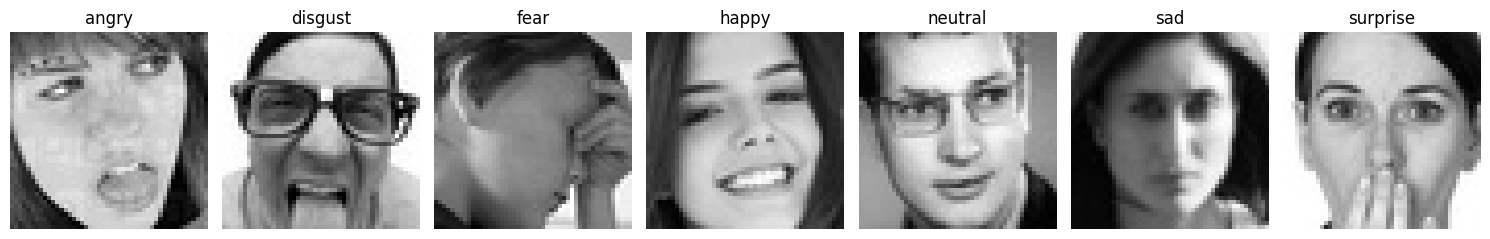

In [16]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Définition des émotions et du chemin du dataset
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
train_path = os.path.join("FER2013", "train")

# Création d'un subplot 1x7 pour éviter l'espace vide
fig, axes = plt.subplots(1, 7, figsize=(15, 5))

for i, emotion in enumerate(emotions):
    emotion_path = os.path.join(train_path, emotion)

    # Vérifie si le dossier contient des images
    if os.path.exists(emotion_path) and len(os.listdir(emotion_path)) > 0:
        img_filename = random.choice(os.listdir(emotion_path))  # Sélection d'une image aléatoire
        img_path = os.path.join(emotion_path, img_filename)

        # Chargement et affichage de l'image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            axes[i].imshow(img, cmap="gray")
            axes[i].set_title(emotion)
        else:
            axes[i].set_title(f"Erreur {emotion}")
    else:
        axes[i].set_title(f"Vide {emotion}")

    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [28]:
# Définition des émotions et du chemin du dataset
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
dataset_path = "FER2013"

# Taille des images pour le CNN
img_size = 48


In [29]:
def load_data(dataset_path, subset, img_size):
    X = []  # Liste des images
    y = []  # Liste des labels (émotions)

    for emotion_idx, emotion in enumerate(emotions):
        emotion_path = os.path.join(dataset_path, subset, emotion)

        # Charger les images
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convertir en niveaux de gris
            img = cv2.resize(img, (img_size, img_size))  # Redimensionner
            X.append(img)
            y.append(emotion_idx)

    return np.array(X), np.array(y)

# Chargement des données d'entraînement et de test
X_train, y_train = load_data(dataset_path, "train", img_size)
X_test, y_test = load_data(dataset_path, "test", img_size)

print(f"Images d'entraînement: {X_train.shape[0]}")
print(f"Images de test: {X_test.shape[0]}")


Images d'entraînement: 28709
Images de test: 7178


In [30]:
# Normalisation des pixels (mettre les valeurs entre 0 et 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape pour correspondre aux entrées du CNN (ajout d’une dimension canal)
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 1)

# Conversion des labels en one-hot encoding
y_train = to_categorical(y_train, num_classes=len(emotions))
y_test = to_categorical(y_test, num_classes=len(emotions))

# Vérification des formes
print(f"Shape X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"Shape X_test : {X_test.shape}, y_test : {y_test.shape}")


Shape X_train : (28709, 48, 48, 1), y_train : (28709, 7)
Shape X_test : (7178, 48, 48, 1), y_test : (7178, 7)


Création du modele

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


- 3 couches de convolution (Conv2D)
- Batch Normalization pour stabiliser l'entraînement
- MaxPooling pour réduire la dimension des features
- Dropout pour éviter l’overfitting
- Une couche Dense de 7 neurones pour la classification finale (softmax)

- Conv2D + BatchNormalization + ReLU → Extrait les caractéristiques de l’image.
- MaxPooling2D → Réduit la taille de l’image pour éviter le sur-apprentissage.
- Flatten → Convertit l’image en un vecteur pour la classification.
- Dense (512 neurones, ReLU) → Réseau de neurones classique pour apprendre les motifs.
- Dense (7 neurones, Softmax) → Prédit la probabilité de chaque émotion.

In [32]:
# Définition des paramètres
input_shape = (48, 48, 1)  # Taille des images en entrée
num_classes = 7  # Nombre d'émotions

# Création du modèle CNN
model = Sequential()

# 1ère couche de convolution
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# 2ème couche de convolution
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# 3ème couche de convolution
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Aplatir les features pour la classification
model.add(Flatten())

# Couche Fully Connected
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout pour éviter l'overfitting

# Couche de sortie (Softmax pour classification multi-classe)
model.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,094,151 (19.43 MB)

 Trainable params: 5,093,255 (19.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Arrêt précoce si la validation n'améliore pas après 5 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Sauvegarde du meilleur modèle
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)


In [42]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[ checkpoint]
)


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6304 - loss: 0.9650 - val_accuracy: 0.5294 - val_loss: 1.2820
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6413 - loss: 0.9194 - val_accuracy: 0.5591 - val_loss: 1.2614
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6622 - loss: 0.8693 - val_accuracy: 0.5623 - val_loss: 1.3046
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6869 - loss: 0.7994 - val_accuracy: 0.5410 - val_loss: 1.4258
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7044 - loss: 0.7631 - val_accuracy: 0.5189 - val_loss: 1.4043
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7320 - loss: 0.6952 - val_accuracy: 0.5709 - val_loss: 1.3950
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7414 - loss: 0.6523 - val_accuracy: 0.5768 - val_loss: 1.3730
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7690 - loss: 0.5997 - val_ac

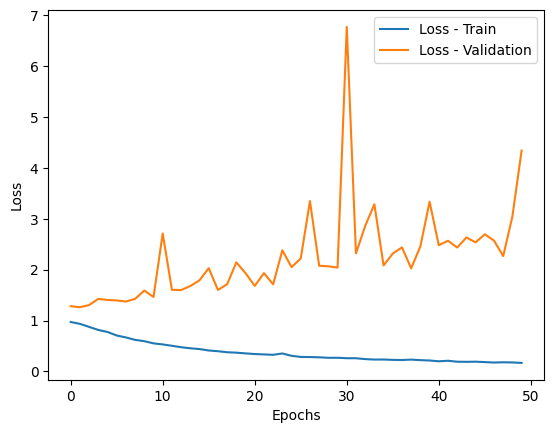

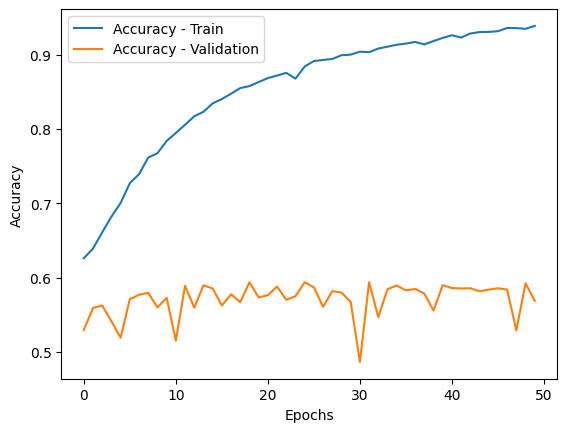

In [43]:
import matplotlib.pyplot as plt

# Affichage de la courbe de perte
plt.plot(history.history['loss'], label='Loss - Train')
plt.plot(history.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Affichage de la courbe d'accuracy
plt.plot(history.history['accuracy'], label='Accuracy - Train')
plt.plot(history.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss sur test: {test_loss:.4f}")
print(f"Accuracy sur test: {test_accuracy:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5103 - loss: 5.1986
Loss sur test: 4.3404
Accuracy sur test: 0.5687


In [45]:
from sklearn.metrics import classification_report
import numpy as np

# Prédiction des classes sur le test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir en labels (0-6)
y_true = np.argmax(y_test, axis=1)  # Labels réels

# Affichage du rapport
print(classification_report(y_true, y_pred_classes, target_names=emotions))


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

       angry       0.52      0.43      0.47       958
     disgust       0.92      0.32      0.47       111
        fear       0.42      0.42      0.42      1024
       happy       0.69      0.83      0.76      1774
     neutral       0.51      0.43      0.46      1233
         sad       0.45      0.48      0.46      1247
    surprise       0.72      0.74      0.73       831

    accuracy                           0.57      7178
   macro avg       0.61      0.52      0.54      7178
weighted avg       0.56      0.57      0.56      7178



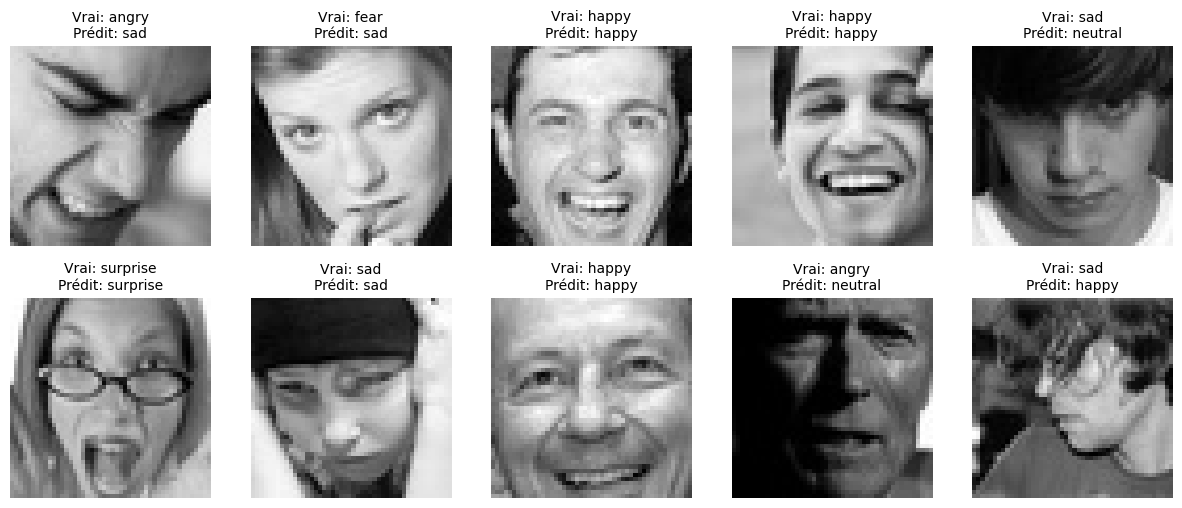

In [46]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(48, 48)  # Reformater l’image
    true_label = emotions[np.argmax(y_test[idx])]
    pred_label = emotions[y_pred_classes[idx]]

    ax = axes[i // 5, i % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=10)
    ax.axis("off")

plt.show()


In [47]:
model.save("emotion_detection_model.h5")
print("✅ Modèle sauvegardé avec succès !")


✅ Modèle sauvegardé avec succès !


In [48]:
from google.colab import files

# Télécharger le fichier sur ton PC
files.download("emotion_detection_model.h5")


FileNotFoundError: Cannot find file: emotion_detection_model_final.h5

In [ ]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Sauvegarder le modèle sur Google Drive
!cp emotion_detection_model.h5 /content/drive/MyDrive/
print("✅ Modèle sauvegardé sur Google Drive !")


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2249 - loss: 2.2539

449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.2250 - loss: 2.2532 - val_accuracy: 0.2471 - val_loss: 1.8291 - learning_rate: 0.0010
Epoch 2/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2582 - loss: 1.7905

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2582 - loss: 1.7905 - val_accuracy: 0.2958 - val_loss: 1.6905 - learning_rate: 0.0010
Epoch 3/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2870 - loss: 1.7492

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.2870 - loss: 1.7491 - val_accuracy: 0.3316 - val_loss: 1.6226 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3206 - loss: 1.6976

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3206 - loss: 1.6976 - val_accuracy: 0.3968 - val_loss: 1.5561 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.3496 - loss: 1.6437 - val_accuracy: 0.4026 - val_loss: 1.5731 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3703 - loss: 1.5918 - val_accuracy: 0.3413 - val_loss: 1.6437 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.3960 - loss: 1.5459 - val_accuracy: 0.3041 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 8/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4203 - loss: 1.4987

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.4203 - loss: 1.4986 - val_accuracy: 0.4886 - val_loss: 1.3200 - learning_rate: 5.0000e-04
Epoch 9/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4351 - loss: 1.4563 - val_accuracy: 0.4896 - val_loss: 1.3382 - learning_rate: 5.0000e-04
Epoch 10/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4544 - loss: 1.4194 - val_accuracy: 0.3376 - val_loss: 1.7281 - learning_rate: 5.0000e-04
Epoch 11/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4616 - loss: 1.4081 - val_accuracy: 0.3972 - val_loss: 1.6290 - learning_rate: 5.0000e-04
Epoch 12/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4768 - loss: 1.3687

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4768 - loss: 1.3687 - val_accuracy: 0.5093 - val_loss: 1.2813 - learning_rate: 2.5000e-04
Epoch 13/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4928 - loss: 1.3349

449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.4927 - loss: 1.3349 - val_accuracy: 0.5210 - val_loss: 1.2523 - learning_rate: 2.5000e-04
Epoch 14/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.4970 - loss: 1.3243 - val_accuracy: 0.4361 - val_loss: 1.5282 - learning_rate: 2.5000e-04
Epoch 15/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.5006 - loss: 1.3095 - val_accuracy: 0.4373 - val_loss: 1.5203 - learning_rate: 2.5000e-04
Epoch 16/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5097 - loss: 1.3032

449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5097 - loss: 1.3032 - val_accuracy: 0.5322 - val_loss: 1.2301 - learning_rate: 2.5000e-04
Epoch 17/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5123 - loss: 1.2943 - val_accuracy: 0.5014 - val_loss: 1.3297 - learning_rate: 2.5000e-04
Epoch 18/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5202 - loss: 1.2801

449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.5202 - loss: 1.2800 - val_accuracy: 0.5419 - val_loss: 1.1810 - learning_rate: 2.5000e-04
Epoch 19/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5171 - loss: 1.2757

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5171 - loss: 1.2756 - val_accuracy: 0.5617 - val_loss: 1.1399 - learning_rate: 2.5000e-04
Epoch 20/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5341 - loss: 1.2458 - val_accuracy: 0.5435 - val_loss: 1.1864 - learning_rate: 2.5000e-04
Epoch 21/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5309 - loss: 1.2450

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5309 - loss: 1.2450 - val_accuracy: 0.5695 - val_loss: 1.1113 - learning_rate: 2.5000e-04
Epoch 22/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5408 - loss: 1.2216 - val_accuracy: 0.5213 - val_loss: 1.2495 - learning_rate: 2.5000e-04
Epoch 23/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5366 - loss: 1.2276 - val_accuracy: 0.5155 - val_loss: 1.3254 - learning_rate: 2.5000e-04
Epoch 24/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5394 - loss: 1.2151 - val_accuracy: 0.5206 - val_loss: 1.2443 - learning_rate: 2.5000e-04
Epoch 25/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5488 - loss: 1.1947

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5488 - loss: 1.1948 - val_accuracy: 0.5858 - val_loss: 1.0782 - learning_rate: 1.2500e-04
Epoch 26/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5477 - loss: 1.2038 - val_accuracy: 0.5761 - val_loss: 1.1122 - learning_rate: 1.2500e-04
Epoch 27/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5507 - loss: 1.1947 - val_accuracy: 0.5828 - val_loss: 1.0866 - learning_rate: 1.2500e-04
Epoch 28/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.5568 - loss: 1.1710 - val_accuracy: 0.5793 - val_loss: 1.1074 - learning_rate: 1.2500e-04
Epoch 29/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5559 - loss: 1.1766 - val_accuracy: 0.5426 - val_loss: 1.1936 - learning_rate: 6.2500e-05
Epoch 30/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5561 - loss: 1.1806 - val_accuracy: 0.5816 - val_loss: 1.0904 - learning_rate: 6.2500e-05
Epoch 31/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - ac

449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5621 - loss: 1.1707 - val_accuracy: 0.5981 - val_loss: 1.0524 - learning_rate: 6.2500e-05
Epoch 32/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5550 - loss: 1.1825 - val_accuracy: 0.5947 - val_loss: 1.0660 - learning_rate: 6.2500e-05
Epoch 33/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5657 - loss: 1.1616 - val_accuracy: 0.5974 - val_loss: 1.0554 - learning_rate: 6.2500e-05
Epoch 34/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5566 - loss: 1.1728 - val_accuracy: 0.5943 - val_loss: 1.0605 - learning_rate: 6.2500e-05
Epoch 35/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5620 - loss: 1.1615

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5620 - loss: 1.1615 - val_accuracy: 0.6032 - val_loss: 1.0423 - learning_rate: 3.1250e-05
Epoch 36/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.5626 - loss: 1.1723 - val_accuracy: 0.5815 - val_loss: 1.0983 - learning_rate: 3.1250e-05
Epoch 37/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5637 - loss: 1.1532

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5637 - loss: 1.1532 - val_accuracy: 0.6034 - val_loss: 1.0350 - learning_rate: 3.1250e-05
Epoch 38/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5747 - loss: 1.1368 - val_accuracy: 0.5956 - val_loss: 1.0555 - learning_rate: 3.1250e-05
Epoch 39/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.5652 - loss: 1.1554 - val_accuracy: 0.5759 - val_loss: 1.1148 - learning_rate: 3.1250e-05
Epoch 40/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5638 - loss: 1.1556 - val_accuracy: 0.5734 - val_loss: 1.1081 - learning_rate: 3.1250e-05
Epoch 41/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5680 - loss: 1.1432 - val_accuracy: 0.6013 - val_loss: 1.0387 - learning_rate: 1.5625e-05
Epoch 42/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5600 - loss: 1.1581 - val_accuracy: 0.5974 - val_loss: 1.0520 - learning_rate: 1.5625e-05
Epoch 43/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - a

449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5716 - loss: 1.1438 - val_accuracy: 0.6082 - val_loss: 1.0318 - learning_rate: 3.9063e-06
Epoch 48/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5703 - loss: 1.1417 - val_accuracy: 0.6084 - val_loss: 1.0341 - learning_rate: 3.9063e-06
Epoch 49/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5713 - loss: 1.1426 - val_accuracy: 0.6030 - val_loss: 1.0402 - learning_rate: 3.9063e-06
Epoch 50/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5690 - loss: 1.1420 - val_accuracy: 0.6067 - val_loss: 1.0392 - learning_rate: 3.9063e-06


✅ Modèle final sauvegardé avec succès !


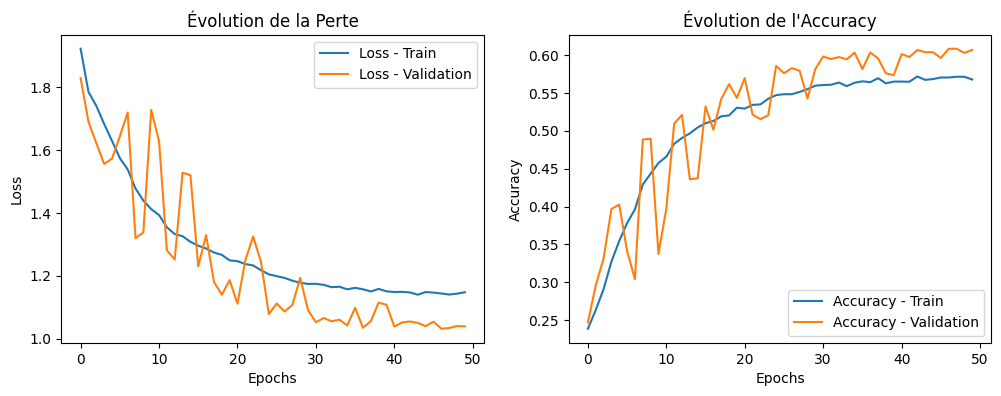

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

X_train = X_train / 255.0
X_test = X_test / 255.0

# ✅ 1️⃣ Augmentation des Données (plus agressive pour meilleure généralisation)
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotation jusqu'à 30 degrés
    width_shift_range=0.1,  # Décalage horizontal
    height_shift_range=0.1,  # Décalage vertical
    zoom_range=0.2,  # Zoom jusqu'à 20%
    horizontal_flip=True  # Inversion horizontale
)

datagen.fit(X_train)

# ✅ 2️⃣ Création du Modèle Optimisé
def create_best_model():
    model = Sequential()

    model.add(InputLayer(input_shape=(48, 48, 1)))

    # Bloc 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    # Bloc 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    # Bloc 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    # Bloc 4 (ajouté pour capturer plus de détails)
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    return model

# ✅ 3️⃣ Compilation avec Adam (learning rate réduit pour meilleure convergence)
best_model = create_best_model()
best_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ 4️⃣ Callbacks pour éviter l'overfitting et améliorer la performance
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_final.h5", monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ✅ 5️⃣ Entraînement du Modèle
history_best = best_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=50,  # Plus d'epochs mais stoppé si overfitting détecté
    batch_size=64,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# ✅ 6️⃣ Sauvegarde du modèle final
best_model.save("emotion_detection_model_best.h5")
print("✅ Modèle final sauvegardé avec succès !")

# ✅ 7️⃣ Affichage des Performances du Modèle
# Courbe de Perte (Loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'], label='Loss - Train')
plt.plot(history_best.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Évolution de la Perte")

# Courbe d'Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_best.history['accuracy'], label='Accuracy - Train')
plt.plot(history_best.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Évolution de l'Accuracy")

plt.show()


In [53]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Sauvegarder le modèle sur Google Drive
!cp emotion_detection_model_best.h5 /content/drive/MyDrive/
print("✅ Modèle sauvegardé sur Google Drive !")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modèle sauvegardé sur Google Drive !


In [52]:
files.download("emotion_detection_model_best.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>